In [2]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from haversine import haversine, Unit, haversine_vector
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import os
from dotenv import load_dotenv
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import lnglat_to_meters

In [3]:
df1=pd.read_csv("/home/moraa/Documents/10_academy/Week-8/Data/driver_locations_during_request.csv")

In [4]:
df2=pd.read_csv("/home/moraa/Documents/10_academy/Week-8/Data/nb.csv")

In [5]:
# Drop the specified columns
df1.drop(columns=['created_at', 'updated_at'], inplace=True)

# Display the DataFrame after dropping the columns
df1.head()

,id,order_id,driver_id,driver_action,lat,lng
0,1,392001,243828,accepted,6.602207,3.270465
1,2,392001,243588,rejected,6.592097,3.287445
2,3,392001,243830,rejected,6.596133,3.281784
3,4,392001,243539,rejected,6.596142,3.280526
4,5,392001,171653,rejected,6.609232,3.288800


In [6]:
df1.head()

,id,order_id,driver_id,driver_action,lat,lng
0,1,392001,243828,accepted,6.602207,3.270465
1,2,392001,243588,rejected,6.592097,3.287445
2,3,392001,243830,rejected,6.596133,3.281784
3,4,392001,243539,rejected,6.596142,3.280526
4,5,392001,171653,rejected,6.609232,3.288800


In [7]:
import pandas as pd

# Impute missing values in Trip Start Time and Trip End Time with mode
df2 = df2.copy()
df2['Trip Start Time'] = df2['Trip Start Time'].fillna(df2['Trip Start Time'].mode()[0])
df2['Trip End Time'] = df2['Trip End Time'].fillna(df2['Trip End Time'].mode()[0])

# Display the DataFrame after imputation
print(df2)

        Trip ID                         Trip Origin  \
0        391996  6.508813001668548,3.37740316890347   
1        391997                 6.4316714,3.4555375   
2        391998         6.631679399999999,3.3388976   
3        391999         6.572757200000001,3.3677082   
4        392001                 6.6010417,3.2766339   
...         ...                                 ...   
536015  1637696         6.448218499999999,3.4772075   
536016  1637702         6.442320899999999,3.4736868   
536017  1637704                  6.4281982,3.492248   
536018  1637705                 6.5869296,3.3632966   
536019  1637709         6.647209999999999,3.4851489   

                            Trip Destination      Trip Start Time  \
0                6.650969799999999,3.3450307  2021-07-01 07:28:04   
1            6.4280814653326,3.4721885847586  2021-07-01 06:38:04   
2                6.508324099999999,3.3590397  2021-07-01 06:21:02   
3                6.584881099999999,3.3614073  2021-07-01 07:16:

# Feature Engineering

Create Day of the Week Feature

In [8]:
# Ensure Trip Start Time is in datetime format
df2['Trip Start Time'] = pd.to_datetime(df2['Trip Start Time'])

# Extract day of the week
df2['Day of Week'] = df2['Trip Start Time'].dt.day_name()

# Display the first few rows to verify
df2[['Trip Start Time', 'Day of Week']].head()


,Trip Start Time,Day of Week
0,2021-07-01 07:28:04,Thursday
1,2021-07-01 06:38:04,Thursday
2,2021-07-01 06:21:02,Thursday
3,2021-07-01 07:16:07,Thursday
4,2021-07-01 09:30:59,Thursday


In [9]:
df2['Day of Week'].nunique()

7

Create Time of Day Category

In [10]:
# Function to categorize time of day
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Extract hour from Trip Start Time
df2['Hour'] = df2['Trip Start Time'].dt.hour

# Apply the function to create time category
df2['Time of Day'] = df2['Hour'].apply(categorize_time_of_day)

# Display the first few rows to verify
df2[['Trip Start Time', 'Hour', 'Time of Day']].head()


,Trip Start Time,Hour,Time of Day
0,2021-07-01 07:28:04,7,Morning
1,2021-07-01 06:38:04,6,Morning
2,2021-07-01 06:21:02,6,Morning
3,2021-07-01 07:16:07,7,Morning
4,2021-07-01 09:30:59,9,Morning


In [11]:
df2['Time of Day'].nunique()

4

Creating Holiday

In [12]:
# Define a list of public holidays in Nigeria for 2021 and 2022
holidays_2021 = [
    '2021-01-01', '2021-04-02', '2021-04-05', '2021-05-01', '2021-05-12', '2021-05-13',
    '2021-06-12', '2021-07-20', '2021-07-21', '2021-10-01', '2021-10-18', '2021-10-19',
    '2021-12-25', '2021-12-26'
]

holidays_2022 = [
    '2022-01-01', '2022-01-03', '2022-04-15', '2022-04-18', '2022-05-01', '2022-05-02',
    '2022-05-03', '2022-05-04', '2022-06-12', '2022-06-13', '2022-07-09', '2022-07-10',
    '2022-07-11', '2022-07-12', '2022-10-01', '2022-10-03', '2022-10-08', '2022-10-09',
    '2022-10-10', '2022-12-25', '2022-12-26', '2022-12-27'
]

# Combine the lists of holidays
all_holidays = pd.to_datetime(holidays_2021 + holidays_2022)

# Create a feature indicating if the date is a holiday
df2['Is Holiday'] = df2['Trip Start Time'].dt.date.isin(all_holidays.date)

df2['Is Holiday'].head()


0    False
1    False
2    False
3    False
4    False
Name: Is Holiday, dtype: bool

In [13]:
df2['Is Holiday'].nunique()

2

Creating the rain Vs no-rain

In [14]:
# Load environment variables from .env file
load_dotenv()

# Get API key from environment
api_key = os.getenv("WEATHER_API_KEY")

# Check for missing values in the latitude and longitude columns of df2
missing_coordinates = df2[['Trip Origin']].isna().any(axis=1)

# Filter out rows with missing coordinates
df2 = df2[~missing_coordinates]

# Create trips list for valid coordinates
trips = df2.apply(lambda row: {'lat': float(row['Trip Origin'].split(',')[0]), 
                               'lon': float(row['Trip Origin'].split(',')[1]), 
                               'timestamp': pd.Timestamp(row['Trip Start Time']).timestamp()}, 
                  axis=1)

# Function to fetch weather data for a single trip
def fetch_weather_single(api_key, lat, lon, timestamp):
    url = f"https://api.openweathermap.org/data/2.5/onecall/timemachine?lat={lat}&lon={lon}&dt={timestamp}&appid={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch weather data for trip at {timestamp}")
        return None

# Function to fetch weather data for multiple trips concurrently
def fetch_weather_batch(api_key, trips):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(fetch_weather_single, [api_key] * len(trips), 
                                     [trip['lat'] for trip in trips], 
                                     [trip['lon'] for trip in trips], 
                                     [trip['timestamp'] for trip in trips]))
    return results

# Fetch weather data for multiple trips concurrently
weather_data = fetch_weather_batch(api_key, trips)

# Process weather data
rain_info = process_weather_data(weather_data)

# Integrate rain information into df2
df2['Is Raining'] = rain_info

# Display the updated DataFrame
print(df2)



Failed to fetch weather data for trip at 1625122288.0
Failed to fetch weather data for trip at 1625120462.0
Failed to fetch weather data for trip at 1625121787.0
Failed to fetch weather data for trip at 1625129049.0
Failed to fetch weather data for trip at 1625136816.0
Failed to fetch weather data for trip at 1625123496.0
Failed to fetch weather data for trip at 1625124484.0
Failed to fetch weather data for trip at 1625121591.0
Failed to fetch weather data for trip at 1625123767.0
Failed to fetch weather data for trip at 1625122177.0
Failed to fetch weather data for trip at 1625121484.0
Failed to fetch weather data for trip at 1625131859.0
Failed to fetch weather data for trip at 1625125710.0
Failed to fetch weather data for trip at 1625126429.0
Failed to fetch weather data for trip at 1625124060.0
Failed to fetch weather data for trip at 1625123975.0
Failed to fetch weather data for trip at 1625125701.0
Failed to fetch weather data for trip at 1625124653.0
Failed to fetch weather data

Feature Extraction and Scaling

In [8]:
# Function to calculate distance between two geographical points
def calculate_distance(row, lat1, lon1, lat2, lon2):
    point1 = (row[lat1], row[lon1])
    point2 = (row[lat2], row[lon2])
    return geodesic(point1, point2).kilometers

# Calculate distance between driver location and trip origin
df_merged['Driver Distance to Origin'] = df_merged.apply(lambda row: calculate_distance(row, 'lat', 'lng', 'Origin Lat', 'Origin Lng'), axis=1)

# Calculate distance between trip origin and destination
df_merged['Trip Distance'] = df_merged.apply(lambda row: calculate_distance(row, 'Origin Lat', 'Origin Lng', 'Destination Lat', 'Destination Lng'), axis=1)

# Extract time of day feature
def get_time_of_day(hour):
    if hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df_merged['Time of Day'] = df_merged['Start Hour'].apply(get_time_of_day)

# Convert 'Time of Day' to categorical feature
df_merged['Time of Day'] = df_merged['Time of Day'].astype('category')

# Select relevant features for scaling
features_to_scale = ['lat', 'lng', 'Origin Lat', 'Origin Lng', 'Destination Lat', 'Destination Lng', 'Trip Duration', 'Driver Distance to Origin', 'Trip Distance']

# Initialize scaler (using StandardScaler for now, MinMaxScaler can be used alternatively)
scaler = StandardScaler()

# Fit and transform the selected features
df_merged[features_to_scale] = scaler.fit_transform(df_merged[features_to_scale])

# Convert categorical features to dummy/indicator variables
df_merged = pd.get_dummies(df_merged, columns=['Time of Day', 'Start Day of Week'])

# Display the first few rows of the transformed dataframe
print(df_merged.head())


   id  Trip ID  driver_id driver_action       lat       lng  \
0   1   392001     243828      accepted  1.103260 -2.032688   
1   2   392001     243588      rejected  0.934718 -1.714323   
2   3   392001     243830      rejected  1.002008 -1.820457   
3   4   392001     243539      rejected  1.002145 -1.844041   
4   5   392001     171653      rejected  1.220381 -1.688913   

           Trip Origin     Trip Destination     Trip Start Time  \
0  6.6010417,3.2766339  6.4501069,3.3916154 2021-07-01 09:30:59   
1  6.6010417,3.2766339  6.4501069,3.3916154 2021-07-01 09:30:59   
2  6.6010417,3.2766339  6.4501069,3.3916154 2021-07-01 09:30:59   
3  6.6010417,3.2766339  6.4501069,3.3916154 2021-07-01 09:30:59   
4  6.6010417,3.2766339  6.4501069,3.3916154 2021-07-01 09:30:59   

        Trip End Time  ...  Time of Day_Evening  Time of Day_Morning  \
0 2021-07-01 09:34:36  ...                False                 True   
1 2021-07-01 09:34:36  ...                False                 True   
2 

Computes Distances, driving speed, shortest Distances, driving route distances and other key variables

In [9]:
# Function to clean latitude values
def clean_latitude(lat):
    if lat < -90:
        return -90  # Replace latitude less than -90 with -90
    elif lat > 90:
        return 90   # Replace latitude greater than 90 with 90
    return lat

# Apply latitude cleaning to 'Origin Lat' and 'Destination Lat' columns
df_merged['Origin Lat'] = df_merged['Origin Lat'].apply(clean_latitude)
df_merged['Destination Lat'] = df_merged['Destination Lat'].apply(clean_latitude)

# Function to compute geodesic distance
def compute_geodesic_distance(row):
    lat1 = row['Origin Lat']
    lon1 = row['Origin Lng']
    lat2 = row['Destination Lat']
    lon2 = row['Destination Lng']
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geodesic(coords_1, coords_2).kilometers

# Function to compute Haversine distance
def compute_haversine_distance(row):
    lat1 = row['Origin Lat']
    lon1 = row['Origin Lng']
    lat2 = row['Destination Lat']
    lon2 = row['Destination Lng']
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return haversine(coords_1, coords_2, unit=Unit.KILOMETERS)

# Function to compute driving speed
def compute_driving_speed(row):
    distance = row['Haversine Distance']
    duration = row['Trip Duration']
    return distance / (duration / 60)  # in km/h

# Compute geodesic distance for each row
df_merged['Geodesic Distance'] = df_merged.apply(compute_geodesic_distance, axis=1)

# Compute haversine distance for each row
df_merged['Haversine Distance'] = df_merged.apply(compute_haversine_distance, axis=1)

# Compute average speed for each row
df_merged['Average Speed'] = df_merged.apply(compute_driving_speed, axis=1)

# Display the updated DataFrame
print(df_merged)




              id  Trip ID  driver_id driver_action       lat       lng  \
0              1   392001     243828      accepted  1.103260 -2.032688   
1              2   392001     243588      rejected  0.934718 -1.714323   
2              3   392001     243830      rejected  1.002008 -1.820457   
3              4   392001     243539      rejected  1.002145 -1.844041   
4              5   392001     171653      rejected  1.220381 -1.688913   
...          ...      ...        ...           ...       ...       ...   
1557735  1557736   517948     243774      rejected -1.116936  3.524931   
1557736  1557737   517948     245447      rejected -1.843909  2.783971   
1557737  1557738   517948     239866      rejected -1.600805  2.746854   
1557738  1557739   517948     243774      rejected -1.116936  3.524931   
1557739  1557740   517948     244170      rejected -1.111036  3.622475   

                         Trip Origin             Trip Destination  \
0                6.6010417,3.2766339      

In [10]:
df_merged.head()

,id,Trip ID,driver_id,driver_action,lat,lng,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,...,Start Day of Week_0,Start Day of Week_1,Start Day of Week_2,Start Day of Week_3,Start Day of Week_4,Start Day of Week_5,Start Day of Week_6,Geodesic Distance,Haversine Distance,Average Speed
0,1,392001,243828,accepted,1.103260,-2.032688,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,...,False,False,False,True,False,False,False,339.802736,340.662877,688863.580397
1,2,392001,243588,rejected,0.934718,-1.714323,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,...,False,False,False,True,False,False,False,339.802736,340.662877,688863.580397
2,3,392001,243830,rejected,1.002008,-1.820457,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,...,False,False,False,True,False,False,False,339.802736,340.662877,688863.580397
3,4,392001,243539,rejected,1.002145,-1.844041,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,...,False,False,False,True,False,False,False,339.802736,340.662877,688863.580397
4,5,392001,171653,rejected,1.220381,-1.688913,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,...,False,False,False,True,False,False,False,339.802736,340.662877,688863.580397


Computes the number of riders and order in circles of 500m from accepted and unfulfilled orders

In [ ]:
# Define the radius of the circle (500m)
radius = 0.5  # in kilometers

# Initialize counters
accepted_riders_in_circle = 0

# Iterate over accepted orders
for _, order in df_merged[df_merged['driver_action'] == 'accepted'].iterrows():
    order_lat = order['lat']
    order_lon = order['lng']
    
    # Count riders within the circle
    for _, rider in df_merged.iterrows():
        rider_lat = rider['lat']
        rider_lon = rider['lng']
        distance = haversine((order_lat, order_lon), (rider_lat, rider_lon))
        if distance <= radius:
            accepted_riders_in_circle += 1

# Print the results
print("Number of riders within 500m of accepted orders:", accepted_riders_in_circle)


Compute clusters of delivery starting locations and destinations and plot how they are distributed in the city.

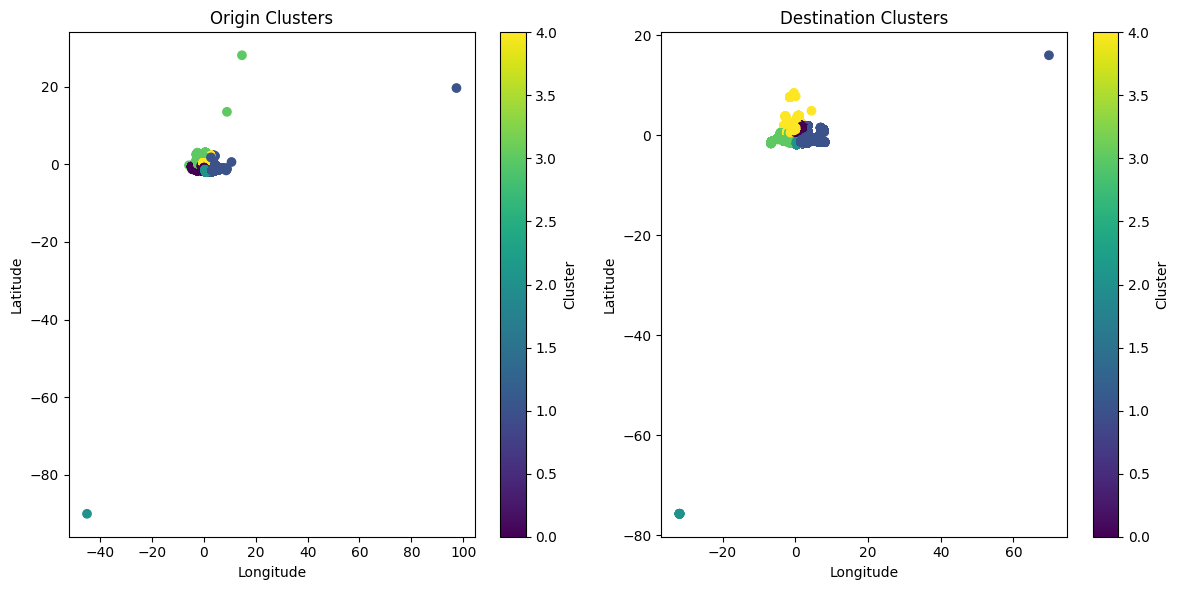

: 

In [11]:
# Extract scaled origin and destination locations
origin_locations_scaled = df_merged[['Origin Lat', 'Origin Lng']].values
destination_locations_scaled = df_merged[['Destination Lat', 'Destination Lng']].values

# Choose the number of clusters
n_clusters = 5  # Adjust as needed

# Cluster the origin locations
kmeans_origin = KMeans(n_clusters=n_clusters, random_state=42)
origin_clusters = kmeans_origin.fit_predict(origin_locations_scaled)

# Cluster the destination locations
kmeans_destination = KMeans(n_clusters=n_clusters, random_state=42)
destination_clusters = kmeans_destination.fit_predict(destination_locations_scaled)

# Visualize the clusters
plt.figure(figsize=(12, 6))

# Plot origin clusters
plt.subplot(1, 2, 1)
plt.scatter(df_merged['Origin Lng'], df_merged['Origin Lat'], c=origin_clusters, cmap='viridis')
plt.title('Origin Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')

# Plot destination clusters
plt.subplot(1, 2, 2)
plt.scatter(df_merged['Destination Lng'], df_merged['Destination Lat'], c=destination_clusters, cmap='viridis')
plt.title('Destination Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()


In [12]:
import datashader.transfer_functions as tf
import datashader as ds

# Set the resolution of the plot
plot_width, plot_height = 200, 300

# Downsample the data by selecting a subset
subset_df = df_merged.sample(frac=0.1)  # Adjust the fraction as needed

# Create the canvas
cvs_origin = ds.Canvas(plot_width=plot_width, plot_height=plot_height)
cvs_destination = ds.Canvas(plot_width=plot_width, plot_height=plot_height)

# Aggregate the data into larger bins
agg_origin = cvs_origin.points(subset_df, 'lng', 'lat')
agg_destination = cvs_destination.points(subset_df, 'Destination Lng', 'Destination Lat')

# Shade the aggregated data
img_origin = tf.shade(agg_origin, cmap=['lightblue', 'darkblue'], how='log')
img_destination = tf.shade(agg_destination, cmap=['lightgreen', 'darkgreen'], how='log')

# Display the plots
img_origin + img_destination


